# Exploring the arXMLiv dataset

arXMLiv 08.2018 - An HTML5 dataset for arXiv.org Data

In [157]:
import os

DATA_BASE_DIR = "/Volumes/Backup/no_problem"

Let's start by getting a overview over our dataset structure

In [158]:
files = []
directories = []
# r=root, d=directories, f = files
for r, d, f in os.walk(DATA_BASE_DIR):
    for directory in d:
        directories.append(os.path.join(r, directory))
    for file in f:
        if '.html' in file:
            files.append(os.path.join(r, file))

print(len(files))
print(files[:10])



150701
['/Volumes/Backup/no_problem/0001/astro-ph0001008.html', '/Volumes/Backup/no_problem/0001/astro-ph0001032.html', '/Volumes/Backup/no_problem/0001/astro-ph0001034.html', '/Volumes/Backup/no_problem/0001/astro-ph0001039.html', '/Volumes/Backup/no_problem/0001/astro-ph0001042.html', '/Volumes/Backup/no_problem/0001/astro-ph0001045.html', '/Volumes/Backup/no_problem/0001/astro-ph0001060.html', '/Volumes/Backup/no_problem/0001/astro-ph0001062.html', '/Volumes/Backup/no_problem/0001/astro-ph0001065.html', '/Volumes/Backup/no_problem/0001/astro-ph0001068.html']


In [159]:
print(len(directories))
print(directories[:10])

337
['/Volumes/Backup/no_problem/0001', '/Volumes/Backup/no_problem/0002', '/Volumes/Backup/no_problem/0003', '/Volumes/Backup/no_problem/0004', '/Volumes/Backup/no_problem/0005', '/Volumes/Backup/no_problem/0006', '/Volumes/Backup/no_problem/0007', '/Volumes/Backup/no_problem/0008', '/Volumes/Backup/no_problem/0009', '/Volumes/Backup/no_problem/0010']


In [160]:
 with open(files[0], "rt") as file:
     print(file.read())

<!DOCTYPE html><html>
<head>
<title>1 Introduction</title>
<!--Generated on Wed Jul  3 19:45:58 2019 by LaTeXML (version 0.8.4) http://dlmf.nist.gov/LaTeXML/.-->

<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
</head>
<body>
<div class="ltx_page_main">
<div class="ltx_page_content">
<article class="ltx_document">
<div class="ltx_abstract">
<h6 class="ltx_title ltx_title_abstract">Abstract</h6>
<p id="id1" class="ltx_p"><span id="id1.1" class="ltx_text ltx_font_italic">In 1997 the first optical afterglow of a cosmic Gamma-Ray
Burst was discovered, and substantial progress
has been achieved since then. Here we present a short review of
some recent developments in this field, with
emphasis on observational aspects of the GRB phenomenon.</span></p>
</div>
<div id="p1" class="ltx_para ltx_align_center">
<p id="p1.1" class="ltx_p"><span id="p1.1.1" class="ltx_text ltx_font_bold" style="font-size:144%;">Gamma-Ray Bursts in the 1990’s –</span></p>
<p id="p1.2" class="ltx_p

We have 337 folders containing 150701 HTML5 documents taking up 60,25 gigabytes of storage. The only useful metadata associated with these files is their [arXiv-Identifier](https://arxiv.org/help/arxiv_identifier) which is used as the filename. 



## Text extraction



In [161]:
from bs4 import BeautifulSoup

def read_file(file):
    with open(file, "rt") as file:
        return file.read()

raw_file = read_file(files[0])
soup = BeautifulSoup(raw_file, features="html.parser")
print(soup.get_text())






1 Introduction








Abstract
In 1997 the first optical afterglow of a cosmic Gamma-Ray
Burst was discovered, and substantial progress
has been achieved since then. Here we present a short review of
some recent developments in this field, with
emphasis on observational aspects of the GRB phenomenon.


Gamma-Ray Bursts in the 1990’s –
[0.2cm]
a Multi-wavelengths Scientific Adventure111to appear in:
R. E. Schielicke (ed.),
Reviews in Modern Astronomy, Vol. 13 (Hamburg: Astronomische
Gesellschaft)
[0.7cm]
Sylvio Klose
[0.17cm]
Thüringer Landessternwarte Tautenburg
D–07778 Tautenburg, Germany
klose@tls-tautenburg.de, http://www.tls-tautenburg.de



1 Introduction

Gamma-Ray Bursts (GRBs) are bright, transient events in the gamma-ray
sky, unpredictable in time and location, with a typical duration of
∼similar-toRELOP:similar-to\sim seconds (for a review, see Fishman 1995; 1999; Fishman &
Meegan 1995; Kouveliotou 1995a; Meegan 1998). The brightest bursts have
gamma-ray fluences of order 

In [162]:
print("Size reduction {:f}".format(len(soup.get_text()) / len(raw_file)))

Size reduction 0.296405


We can extract the text relatively easily with BeautifulSoup. The text looks quite usable on the first glance and even this simple preprocessing dropped the size of the content down to 29% of the original size.
But a closer look reveals artifacts like ```POSTSUBSCRIPT:start italic-nu POSTSUBSCRIPT:end OPEN:( italic-t CLOSE:)```. Additional postprocessing is needed.

Let's have a look at the unusual html-tags in the file.


In [163]:
def unusual_tags(soup):
    # preload of some very common tags to reduce noise in the output
    usual_tags = ['html', 'head', 'title', 'meta', 'body', 'div', 'article', 'p', 'section', 'span']
    unusual_tag_types = []
    unusual_content = []

    for tag in soup.find_all():
        if tag.name not in usual_tags:
            if tag.name not in unusual_content:
                unusual_tag_types.append(tag.name)
                unusual_content.append(tag)
            
    print(unusual_tag_types)
    print(unusual_content)

unusual_tags(soup)




['h6', 'sup', 'sup', 'h2', 'math', 'semantics', 'mo', 'annotation-xml', 'csymbol', 'annotation', 'annotation', 'math', 'semantics', 'msup', 'mi', 'mrow', 'mo', 'mn', 'annotation-xml', 'apply', 'apply', 'minus', 'cn', 'annotation', 'annotation', 'math', 'semantics', 'msup', 'mi', 'mrow', 'mo', 'mn', 'annotation-xml', 'apply', 'apply', 'minus', 'cn', 'annotation', 'annotation', 'math', 'semantics', 'mrow', 'mi', 'mo', 'mi', 'annotation-xml', 'apply', 'times', 'ci', 'ci', 'annotation', 'annotation', 'h2', 'h3', 'math', 'semantics', 'mi', 'annotation-xml', 'ci', 'annotation', 'annotation', 'h3', 'h2', 'math', 'semantics', 'mi', 'annotation-xml', 'ci', 'annotation', 'annotation', 'math', 'semantics', 'mi', 'annotation-xml', 'ci', 'annotation', 'annotation', 'figure', 'figcaption', 'table', 'thead', 'tr', 'th', 'th', 'math', 'semantics', 'mi', 'annotation-xml', 'ci', 'annotation', 'annotation', 'math', 'semantics', 'msup', 'mi', 'mpadded', 'mi', 'annotation-xml', 'apply', 'ci', 'annotation',

Skimming the list of ununusal tags shows the repeated occurence of ```MathMl```-tags and the footer only containing the note that LateXml was used for the conversion. Dropping these should further clean up the text.

In [164]:
soup = BeautifulSoup(read_file(files[0]), features="html.parser")
for script in soup(["math", "footer"]):
    script.extract()

unusual_tags(soup)

reduced_text = soup.get_text()



['h6', 'sup', 'sup', 'h2', 'h2', 'h3', 'h3', 'h2', 'figure', 'figcaption', 'table', 'thead', 'tr', 'th', 'th', 'th', 'th', 'th', 'th', 'th', 'tbody', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'tr', 'td', 'td', 'td', 'td', 'td', 'td', 'td', 'br', 'br', 'br', 'h2', 'h2', 'a', 'sup', 'sup', 'h2', 'sup', 'sup', 'h2', 'ul', 'li', 'li', 'br', 'li', 'br', 'li', 'br', 'li', 'br', 'li', 'li', 'li', 'li', 'li', 'dl', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', 'dd', 'dt', '

In [165]:
print("Size reduction {:f}".format(len(soup.get_text()) / len(raw_file)))

Size reduction 0.273502


In [166]:
print(soup.get_text())



1 Introduction








Abstract
In 1997 the first optical afterglow of a cosmic Gamma-Ray
Burst was discovered, and substantial progress
has been achieved since then. Here we present a short review of
some recent developments in this field, with
emphasis on observational aspects of the GRB phenomenon.


Gamma-Ray Bursts in the 1990’s –
[0.2cm]
a Multi-wavelengths Scientific Adventure111to appear in:
R. E. Schielicke (ed.),
Reviews in Modern Astronomy, Vol. 13 (Hamburg: Astronomische
Gesellschaft)
[0.7cm]
Sylvio Klose
[0.17cm]
Thüringer Landessternwarte Tautenburg
D–07778 Tautenburg, Germany
klose@tls-tautenburg.de, http://www.tls-tautenburg.de



1 Introduction

Gamma-Ray Bursts (GRBs) are bright, transient events in the gamma-ray
sky, unpredictable in time and location, with a typical duration of
 seconds (for a review, see Fishman 1995; 1999; Fishman &
Meegan 1995; Kouveliotou 1995a; Meegan 1998). The brightest bursts have
gamma-ray fluences of order 10 erg cm, strong enough
to lea

## Combining the techniques 

Let's use these techniques and combine them with some normal string cleaning to create a cleanup function.

In [167]:
import re

def get_text(file):
    soup = BeautifulSoup(read_file(file), features="html.parser")
    for script in soup(["math", "footer"]):
        script.extract()
    text = soup.get_text()
    text = text.lower()
    text = text.replace("\n", " ")
    text = re.sub(r"n't|'[A-Za-z]+", '', text) # drop the all contrations since they are all stopwords I've -> I
    text = re.sub(r'[^a-zA-Z\s:]', '', text) # drop non alphabetic characters
    text = re.sub(" +", " ", text)

    return text

print(get_text(files[0]))


 introduction abstract in the first optical afterglow of a cosmic gammaray burst was discovered and substantial progress has been achieved since then here we present a short review of some recent developments in this field with emphasis on observational aspects of the grb phenomenon gammaray bursts in the s cm a multiwavelengths scientific adventureto appear in: r e schielicke ed reviews in modern astronomy vol hamburg: astronomische gesellschaft cm sylvio klose cm thringer landessternwarte tautenburg d tautenburg germany klosetlstautenburgde http:wwwtlstautenburgde introduction gammaray bursts grbs are bright transient events in the gammaray sky unpredictable in time and location with a typical duration of seconds for a review see fishman fishman meegan kouveliotou a meegan the brightest bursts have gammaray fluences of order erg cm strong enough to lead to detectable disturbances of the earths upper atmosphere fishman inan most of the energy of the bursts is released in the mev range

In [168]:
import spacy 
import re
import sys

from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm

In [169]:
!python -m spacy download en_core_web_sm

You should consider upgrading via the '/Users/bockstaller/Documents/code/vocabulary-extraction/.venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [170]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'tagger', 'parser']) # and disable the tagger, parser and ner.
stopwords = nlp.Defaults.stop_words # load the list of stopwords from spacy for the English language
stemmer = PorterStemmer() ### initialize the stemmer from NLTK

def remove_stopwords_and_stem(text):
    tokens_without_stopwords = [token for token in nlp(text) if not token.text in stopwords]
    stemmed_tokens = [stemmer.stem(token.text) for token in tokens_without_stopwords if len(token.text) > 1]
    text = " ".join(stemmed_tokens)
    return(re.sub("\s{2,}", " ", text))

print(remove_stopwords_and_stem(get_text(files[0])))
        

introduct abstract optic afterglow cosmic gammaray burst discov substanti progress achiev present short review recent develop field emphasi observ aspect grb phenomenon gammaray burst cm multiwavelength scientif adventureto appear schielick ed review modern astronomi vol hamburg astronomisch gesellschaft cm sylvio klose cm thringer landessternwart tautenburg tautenburg germani klosetlstautenburgd http wwwtlstautenburgd introduct gammaray burst grb bright transient event gammaray sky unpredict time locat typic durat second review fishman fishman meegan kouveliot meegan brightest burst gammaray fluenc order erg cm strong lead detect disturb earth upper atmospher fishman inan energi burst releas mev rang spectra gener display featureless smooth continua review teegarden grb record vela satellit juli klebesadel strong olson strong klebesadel olson histor review bonnel klebesadel precis local grb sky unsolv challeng groundbas astronomi year burst detect numer spacebas experi timespan unsati

In [173]:
from collections import Counter
from copy import deepcopy
import random 
import pandas as pd

AMOUNT_OF_DOCUMENTS = 5000
SEED=42
random.seed(SEED)
chosen_files = random.sample(files,AMOUNT_OF_DOCUMENTS)
nlp.max_length =2000000 

rows = []

complete_counter = Counter()

for index, file in enumerate(chosen_files):
    raw_file = read_file(file)
    raw_length = len(raw_file)
    

    text = get_text(file)
    text_length = len(text)
    
    cleaned_text = remove_stopwords_and_stem(text)
    cleaned_length = len(cleaned_text)

    tokens = cleaned_text.split(" ")

    amount_of_words = len(tokens)

    counter = Counter()
    counter.update(tokens)
    unique_words = len(counter.keys())

    complete_counter.update(counter)
    total_words=len(complete_counter.keys())

    row = [raw_length, text_length, cleaned_length, amount_of_words, unique_words, total_words ]
    rows.append(row)

df = pd.DataFrame(rows, columns=["raw_length", "text_length", "cleaned_length", "amount_of_words", "unique_words", "total_words"])
df

    


,raw_length,text_length,cleaned_length,amount_of_words,unique_words,total_words
0,743187,76312,46034,6761,1281,1281
1,376540,11109,5968,847,281,1436
2,361826,37647,23132,3493,1006,2054
3,657429,44148,26725,3879,876,2445
4,274536,19365,11834,1781,654,2665
...,...,...,...,...,...,...
4995,347876,33197,20810,3189,978,215939
4996,114667,15085,8906,1306,472,215951
4997,516027,35053,22302,3240,827,215969
4998,170578,30316,17889,2714,592,215990


In [179]:
df= pd.read_pickle("results_5000")

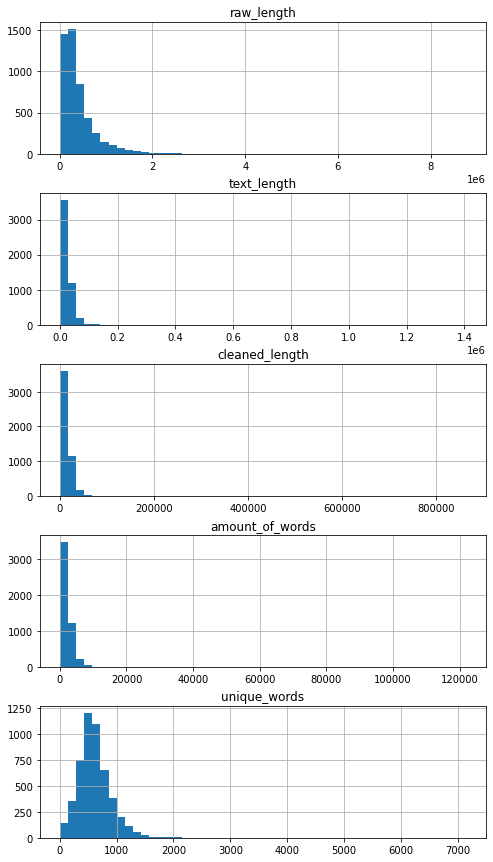

In [175]:


ax = df.loc[:, df.columns != 'total_words'].hist(layout=(5,1),bins=50, figsize=(8,15))


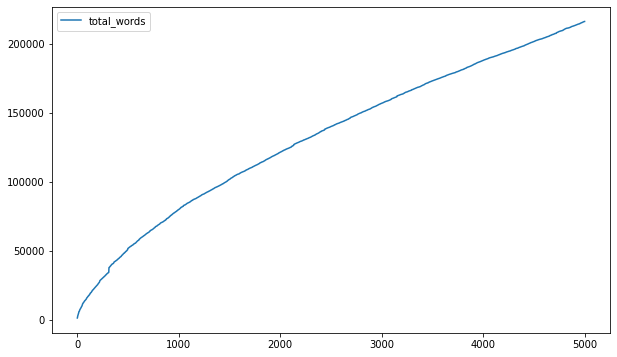

In [176]:
ax = df.loc[:, df.columns == 'total_words'].plot.line(layout=(1,1), figsize=(10,6))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

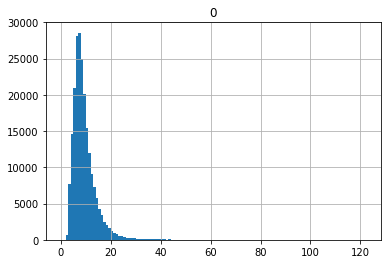

In [180]:
import collections
word_length = [len(x) for x in complete_counter.keys()]
word_length_df = pd.DataFrame(word_length)

word_length_df.hist(bins=max(word_length)-min(word_length))